#  Computed Tomography Emphysema Database — Tổng quan

**Mục tiêu notebook:** xây dựng pipeline cho **phân loại 4 lớp emphysema** trên lát CT (NT, CLE, PSE, PLE) từ bộ dữ liệu của L. Sørensen et al., IEEE TMI 2010.

**Trích dẫn bắt buộc khi công bố:**
L. Sørensen, S. B. Shaker, and M. de Bruijne, *Quantitative Analysis of Pulmonary Emphysema using Local Binary Patterns*, IEEE TMI 29(2):559–569, 2010.

**Điều kiện sử dụng:** miễn phí cho nghiên cứu/giáo dục; **không** phân phối lại hay thương mại hóa.



- 115 lát **512×512**, TIFF **16-bit**, ba vị trí: `top | middle | bottom`.
- 39 **subjects** (9 never-smokers, 10 smokers, 20 COPD).
- `slice_labels.csv`: **leading pattern** của lát (1 NT, 2 CLE, 3 PSE, 4 PLE).
- `slice_severity.csv`: mức độ 0–5 *(không dùng trực tiếp cho 4-class)*.
- `patches`: 168 ROI, **3 lớp** (NT, CLE, PSE) *(không dùng vì thiếu PLE)*.


##  Mã hóa nhãn & phạm vi sử dụng trong bài toán này

**Sẽ dùng:**
- Ảnh lát: `slices/subject{ID}_{level}.tif`
- Nhãn 4 lớp: `slices/slice_labels.csv`
- Danh sách bệnh nhân: `subjects.csv`

**Không dùng (trong baseline 4-class):**
- `slice_severity.csv` (chỉ cho phân tích phụ/đa nhiệm).
- Thư mục `patches/*` (chỉ có 3 lớp, không có PLE).

**Ánh xạ nhãn (pattern_code):**
- `1 → NT` (Normal Tissue)
- `2 → CLE` (Centrilobular Emphysema)
- `3 → PSE` (Paraseptal Emphysema)
- `4 → PLE` (Panlobular Emphysema)


In [1]:
#!python -m venv mlenv

In [2]:
#!mlenv\Scripts\python -m pip install --upgrade pip
#!mlenv\Scripts\python -m pip install ipykernel


     ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
     -- ------------------------------------- 0.1/1.8 MB 3.3 MB/s eta 0:00:01
     ------ --------------------------------- 0.3/1.8 MB 3.8 MB/s eta 0:00:01
     ------------- -------------------------- 0.6/1.8 MB 4.8 MB/s eta 0:00:01
     ------------------- -------------------- 0.9/1.8 MB 4.9 MB/s eta 0:00:01
     ------------------------------------- -- 1.7/1.8 MB 7.1 MB/s eta 0:00:01
     ------------------------------------- -- 1.7/1.8 MB 7.1 MB/s eta 0:00:01
     ------------------------------------- -- 1.7/1.8 MB 7.1 MB/s eta 0:00:01
     ------------------------------------- -- 1.7/1.8 MB 7.1 MB/s eta 0:00:01
     -------------------------------------- - 1.7/1.8 MB 4.2 MB/s eta 0:00:01
     -------------------------------------- - 1.7/1.8 MB 3.9 MB/s eta 0:00:01
     ---------------------------------------  1.7/1.8 MB 3.5 MB/s eta 0:00:01
     ---------------------------------------- 1.8/1.8 MB 3.3 MB/s eta 0

In [3]:
#!mlenv\Scripts\python -m ipykernel install --user --name=mlenv --display-name "Python (mlenv)"


Installed kernelspec mlenv in C:\Users\admin\AppData\Roaming\jupyter\kernels\mlenv


In [4]:
#!pip install --only-binary :all: numpy==1.26.4 pandas==2.2.2
#!pip install scikit-image==0.24.0 albumentations==1.3.1 opencv-python-headless==4.10.0.84
#!pip install matplotlib==3.8.4 scikit-learn==1.4.2 tqdm==4.66.5


     ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
     ---------------------------------------- 0.1/15.8 MB 2.2 MB/s eta 0:00:08
      --------------------------------------- 0.3/15.8 MB 3.0 MB/s eta 0:00:06
     - -------------------------------------- 0.6/15.8 MB 4.3 MB/s eta 0:00:04
     -- ------------------------------------- 0.8/15.8 MB 5.3 MB/s eta 0:00:03
     ---- ----------------------------------- 1.7/15.8 MB 7.1 MB/s eta 0:00:02
     ----- ---------------------------------- 2.0/15.8 MB 7.3 MB/s eta 0:00:02
     ------- -------------------------------- 2.8/15.8 MB 8.6 MB/s eta 0:00:02
     -------- ------------------------------- 3.2/15.8 MB 8.6 MB/s eta 0:00:02
     --------- ------------------------------ 3.8/15.8 MB 9.0 MB/s eta 0:00:02
     ---------- ----------------------------- 4.2/15.8 MB 9.3 MB/s eta 0:00:02
     ----------- ---------------------------- 4.7/15.8 MB 9.5 MB/s eta 0:00:02
     ------------- -------------------------- 5.3/15.8 MB 9

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     ---------------------------------------- 0.1/12.9 MB 2.6 MB/s eta 0:00:05
      --------------------------------------- 0.3/12.9 MB 3.4 MB/s eta 0:00:04
     - -------------------------------------- 0.6/12.9 MB 4.6 MB/s eta 0:00:03
     -- ------------------------------------- 0.9/12.9 MB 5.5 MB/s eta 0:00:03
     -- ------------------------------------- 0.9/12.9 MB 4.0 MB/s eta 0:00:03
     ------ --------------------------------- 2.0/12.9 MB 8.1 MB/s eta 0:00:02
     ------- -------------------------------- 2.3/12.9 MB 7.6 MB/s eta 0:00:02
     --------- ------------------------------ 3.2/12.9 MB 8.8 MB/s eta 0:00:02
     ----------- ---------------------------- 3.7/12.9 MB 9.0 MB/s eta 0:00:02
     ------------- -------------------------- 4.2/12.9 MB 9.4 MB/s eta 0:00:01
     -------------- ------------------------- 4.8/12.9 MB 9.6 MB/s eta 0:00:01
     ---------------- ----------------------- 5.4/12.9 MB 9


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/7.7 MB ? eta -:--:--
     ---------------------------------------- 0.1/7.7 MB 1.1 MB/s eta 0:00:07
     - -------------------------------------- 0.2/7.7 MB 2.9 MB/s eta 0:00:03
     -- ------------------------------------- 0.5/7.7 MB 3.1 MB/s eta 0:00:03
     --- ------------------------------------ 0.6/7.7 MB 3.8 MB/s eta 0:00:02
     ------- -------------------------------- 1.4/7.7 MB 6.3 MB/s eta 0:00:02
     ---------- ----------------------------- 1.9/7.7 MB 6.9 MB/s eta 0:00:01
     ------------ --------------------------- 2.4/7.7 MB 7.1 MB/s eta 0:00:01
     -------------- ------------------------- 2.8/7.7 MB 7.4 MB/s eta 0:00:01
     ----------------- ---------------------- 3.3/7.7 MB 7.7 MB/s eta 0:00:01
     ------------------- -------------------- 3.7/7.7 MB 7.8 MB/s eta 0:00:01
     --------------------- ------------------ 4.2/7.7 MB 8.1 MB/s eta 0:00:01
     ----------------------- ---------------- 4.6/7.7 MB 8.1 MB/s eta 0


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import sys
!"{sys.executable}" -m pip install --no-cache-dir --only-binary :all: "numpy==1.26.4" "pandas==2.2.2"
!"{sys.executable}" -m pip install scikit-image==0.24.0 albumentations==1.3.1 opencv-python-headless==4.10.0.84 matplotlib==3.8.4 scikit-learn==1.4.2 tqdm==4.66.5



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import Counter

In [23]:
# Cấu hình đường dẫn

plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True

DATA_ROOT = Path("Data")
RAW = DATA_ROOT / "raw" / "Emphysema_Database_Sorensen"
SLICES_DIR = RAW / "slices"

OUT = DATA_ROOT / "processed" / "sorensen"

OUT_IMG  = OUT / "preprocessed" 
OUT_IMG.mkdir(parents=True, exist_ok=True)

OUT_LOG  = OUT / "logs"
OUT_LOG.mkdir(parents=True, exist_ok=True)

MANIFEST_IN  = OUT / "manifest_slices.csv"      # manifest bạn đã lưu
MANIFEST_OUT = OUT / "manifest_slices_preprocessed.csv"

In [8]:
#  Đọc CSV
subjects = pd.read_csv(RAW / "subjects.csv", header=None, names=["subject_key"])
subjects["subject_id"] = subjects["subject_key"].str.extract(r"subject(\d+)", expand=False).astype(int)

slice_labels = pd.read_csv(SLICES_DIR / "slice_labels.csv", header=None, names=["slice_key", "label_code"])
slice_severity = pd.read_csv(SLICES_DIR / "slice_severity.csv", header=None, names=["slice_key", "severity_code"])

display(subjects.head(3))
display(slice_labels.head(3))
display(slice_severity.head(3))

,subject_key,subject_id
0,subject24,24
1,subject9,9
2,subject31,31


,slice_key,label_code
0,subject24_top,1
1,subject24_middle,1
2,subject24_bottom,1


,slice_key,severity_code
0,subject24_top,0
1,subject24_middle,0
2,subject24_bottom,0


In [9]:
# Tạo manifest: parse subject_id, level, gán đường dẫn ảnh, map tên lớp
# Kỳ vọng khóa: slice_key dạng 'subject{ID}_{level}' với level ∈ {top, middle, bottom}
def parse_slice_key(key: str):
    import re
    m = re.match(r"subject(\d+)_(top|middle|bottom)$", key)
    if m:
        return int(m.group(1)), m.group(2)
    return None, None

tmp = []
for k in slice_labels["slice_key"].tolist():
    sid, lvl = parse_slice_key(k)
    tmp.append((k, sid, lvl))
parsed = pd.DataFrame(tmp, columns=["slice_key", "subject_id", "level"])

manifest = slice_labels.merge(parsed, on="slice_key", how="left") \
                       .merge(slice_severity, on="slice_key", how="left")

# ánh xạ nhãn
label_map = {1:"NT", 2:"CLE", 3:"PSE", 4:"PLE"}
manifest["label_name"] = manifest["label_code"].map(label_map)

# level có thứ tự
cat = pd.CategoricalDtype(categories=["top","middle","bottom"], ordered=True)
manifest["level"] = manifest["level"].astype(cat)

# đường dẫn ảnh
manifest["image_path"] = manifest.apply(
    lambda r: (SLICES_DIR / f"subject{r['subject_id']}_{r['level']}.tiff").as_posix(), axis=1
)

# cột 
manifest = manifest[[
    "slice_key","subject_id","level", "label_code","label_name",
    "severity_code","image_path"
]]

display(manifest.head(10))
print("Tổng số dòng manifest:", len(manifest))


,slice_key,subject_id,level,label_code,label_name,severity_code,image_path
0,subject24_top,24,top,1,NT,0,Data/raw/Emphysema_Database_Sorensen/slices/su...
1,subject24_middle,24,middle,1,NT,0,Data/raw/Emphysema_Database_Sorensen/slices/su...
2,subject24_bottom,24,bottom,1,NT,0,Data/raw/Emphysema_Database_Sorensen/slices/su...
3,subject9_top,9,top,1,NT,0,Data/raw/Emphysema_Database_Sorensen/slices/su...
4,subject9_middle,9,middle,1,NT,0,Data/raw/Emphysema_Database_Sorensen/slices/su...
5,subject31_top,31,top,1,NT,0,Data/raw/Emphysema_Database_Sorensen/slices/su...
6,subject31_middle,31,middle,1,NT,0,Data/raw/Emphysema_Database_Sorensen/slices/su...
7,subject31_bottom,31,bottom,1,NT,0,Data/raw/Emphysema_Database_Sorensen/slices/su...
8,subject4_top,4,top,1,NT,0,Data/raw/Emphysema_Database_Sorensen/slices/su...
9,subject4_middle,4,middle,1,NT,0,Data/raw/Emphysema_Database_Sorensen/slices/su...


Tổng số dòng manifest: 115


In [10]:
from pathlib import Path

exists = manifest["image_path"].apply(lambda p: Path(p).exists())
missing = manifest.loc[~exists]
ok = exists.sum()

print(f"Files tồn tại: {ok}/{len(manifest)}")
if not missing.empty:
    print("Các file thiếu (hiển thị tối đa 10):")
    display(missing.head(10))

# Lưu manifest để dùng về sau
manifest.to_csv(OUT / "manifest_slices.csv", index=False)
print("Đã lưu:", (OUT / "manifest_slices.csv").as_posix())

Files tồn tại: 115/115
Đã lưu: Data/processed/sorensen/manifest_slices.csv


In [11]:
# Thống kê theo lớp và theo level
by_label = manifest["label_name"].value_counts().rename_axis("label").reset_index(name="count")
by_level = manifest["level"].value_counts().rename_axis("level").reset_index(name="count")
by_label_level = manifest.groupby(["level","label_name"]).size().reset_index(name="count")

display(by_label)
display(by_level)
display(by_label_level.head(20))

C:\Users\QUANG\AppData\Local\Temp\ipykernel_18136\1048190048.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_label_level = manifest.groupby(["level","label_name"]).size().reset_index(name="count")


,label,count
0,NT,61
1,PSE,27
2,CLE,21
3,PLE,6


,level,count
0,top,39
1,middle,39
2,bottom,37


,level,label_name,count
0,top,CLE,7
1,top,NT,20
2,top,PLE,2
3,top,PSE,10
4,middle,CLE,7
5,middle,NT,21
6,middle,PLE,2
7,middle,PSE,9
8,bottom,CLE,7
9,bottom,NT,20


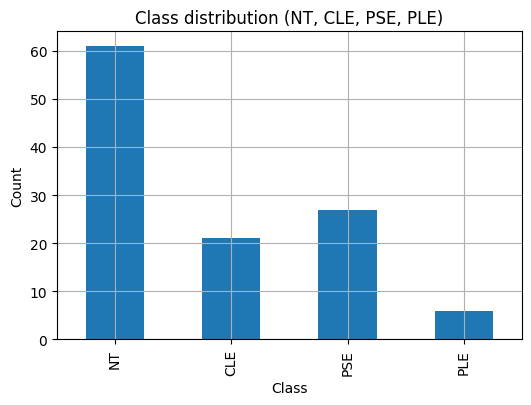

In [12]:
# Biểu đồ cột phân bố lớp
counts = manifest["label_name"].value_counts().reindex(["NT","CLE","PSE","PLE"])
ax = counts.plot(kind="bar")
ax.set_title("Class distribution (NT, CLE, PSE, PLE)")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.show()

###  Class Distribution (NT, CLE, PSE, PLE)

Biểu đồ trên thể hiện **phân bố số lượng lát ảnh (slices)** theo bốn loại mô phổi:
- **NT (Normal Tissue)**: mô phổi bình thường, chiếm phần lớn dữ liệu (~60 lát).  
- **CLE (Centrilobular Emphysema)**: chiếm khoảng 1/4 tổng số.  
- **PSE (Paraseptal Emphysema)** và **PLE (Panlobular Emphysema)**: ít hơn đáng kể.

**Ý nghĩa:** 
Bộ dữ liệu **không cân bằng**, trong đó lớp **NT** chiếm ưu thế rõ rệt, còn **PLE** là lớp hiếm nhất.  



C:\Users\QUANG\AppData\Local\Temp\ipykernel_18136\3784237962.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = manifest.pivot_table(index="level", columns="label_name", values="slice_key", aggfunc="count").fillna(0)


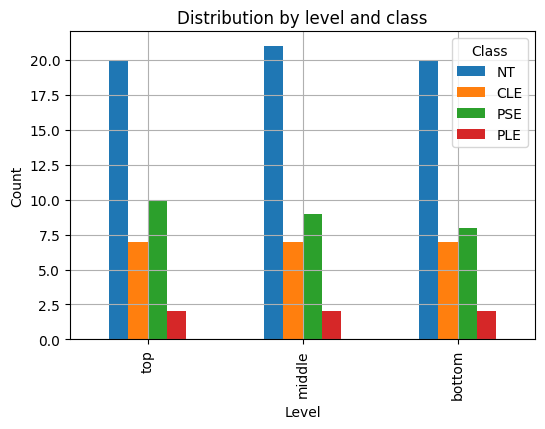

In [13]:
# Biểu đồ cột phân bố lớp theo level (grouped bars)
pivot = manifest.pivot_table(index="level", columns="label_name", values="slice_key", aggfunc="count").fillna(0)
pivot = pivot[["NT","CLE","PSE","PLE"]]  # cố định thứ tự cột
pivot.plot(kind="bar")
plt.title("Distribution by level and class")
plt.xlabel("Level")
plt.ylabel("Count")
plt.legend(title="Class")
plt.show()

###  Distribution by Level and Class

Biểu đồ trên thể hiện **phân bố số lượng lát ảnh (slices)** của từng loại mô phổi (NT, CLE, PSE, PLE)  
theo ba vị trí trong phổi: **top (đỉnh phổi)**, **middle (giữa)** và **bottom (đáy phổi)**.

**Nhận xét:**
- Mỗi level có số lượng lát gần như tương đương, cho thấy dữ liệu được **phân bố đều theo vị trí giải phẫu**.  
- Lớp **NT (Normal Tissue)** chiếm ưu thế ở cả ba vị trí, phản ánh tỷ lệ mô phổi bình thường cao hơn so với các loại emphysema.  
- **CLE** và **PSE** xuất hiện ở cả ba vùng, trong khi **PLE** ít hơn rõ rệt.  



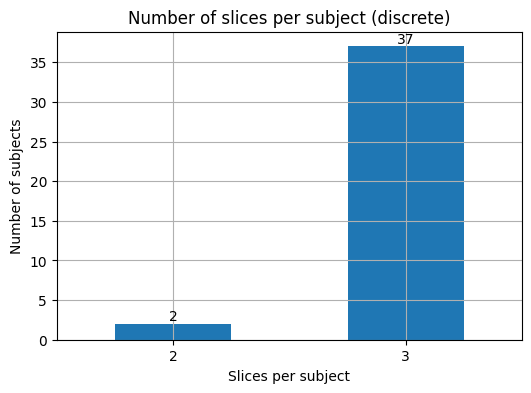

,subjects
2,2
3,37


In [14]:
# Đếm số lát theo subject 
per_subject = manifest.groupby("subject_id").size()

freq = per_subject.value_counts().sort_index()  # index: 2, 3
ax = freq.plot(kind="bar")
ax.set_title("Number of slices per subject (discrete)")
ax.set_xlabel("Slices per subject")
ax.set_ylabel("Number of subjects")
ax.set_xticklabels([str(i) for i in freq.index], rotation=0)


for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom")

plt.show()

# Bảng tần suất
display(freq.rename("subjects").to_frame())


### Number of Slices per Subject

Biểu đồ trên thể hiện **số lượng lát CT (slices)** của mỗi bệnh nhân (**subject_id**) trong bộ dữ liệu.

**Quan sát:**
- Hầu hết bệnh nhân (**37/39**) có **3 lát ảnh**, tương ứng với ba vị trí giải phẫu: **top**, **middle**, **bottom**.  
- Chỉ có **2 bệnh nhân** có **2 lát ảnh**, tức là thiếu một vị trí trong ba lát chuẩn.




In [15]:
# Hàm util: đọc TIFF 16-bit và chuẩn hóa hiển thị
import numpy as np
import cv2

def read_tiff16(path: str):
    # giữ nguyên depth
    img = cv2.imread(path, -1)  # unchanged -> 16-bit giữ nguyên
    if img is None:
        raise FileNotFoundError(path)
    # nếu ảnh có kênh >1, convert về single-channel
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def normalize_for_view(img: np.ndarray, p1=1, p99=99):
    # Chuẩn hóa theo percentile để nhìn rõ (tránh outlier)
    lo = np.percentile(img, p1)
    hi = np.percentile(img, p99)
    img_clipped = np.clip(img, lo, hi)
    if hi > lo:
        view = ((img_clipped - lo) / (hi - lo) * 255.0).astype(np.uint8)
    else:
        view = np.zeros_like(img, dtype=np.uint8)
    return view



Shape: (512, 512) dtype: int16


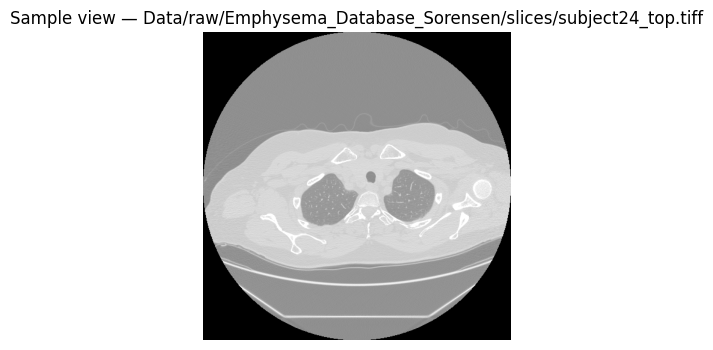

In [16]:
# Show 1 ảnh ngẫu nhiên
sample_path = manifest["image_path"].iloc[0]
img16 = read_tiff16(sample_path)
view = normalize_for_view(img16)
print("Shape:", img16.shape, "dtype:", img16.dtype)
plt.imshow(view, cmap="gray")
plt.title(f"Sample view — {sample_path}")
plt.axis("off")
plt.show()


### Sample CT Slice (Random View)

Ảnh trên minh họa **một lát CT ngẫu nhiên** được lấy từ bộ dữ liệu.  
Kích thước ảnh: **512 x 512 pixel**, kiểu dữ liệu **int16**, cho thấy đây là ảnh CT y khoa tiêu chuẩn.  

**Giải thích:**
- Các vùng **màu xám sáng**: mô phổi đặc hơn (ít khí hơn, có mật độ mô cao).  
- Các vùng **màu xám đậm hoặc đen**: chứa nhiều khí, mật độ thấp (có thể là vùng emphysema).  
- Các cấu trúc trắng ở ngoại vi: xương sườn và thành ngực.  



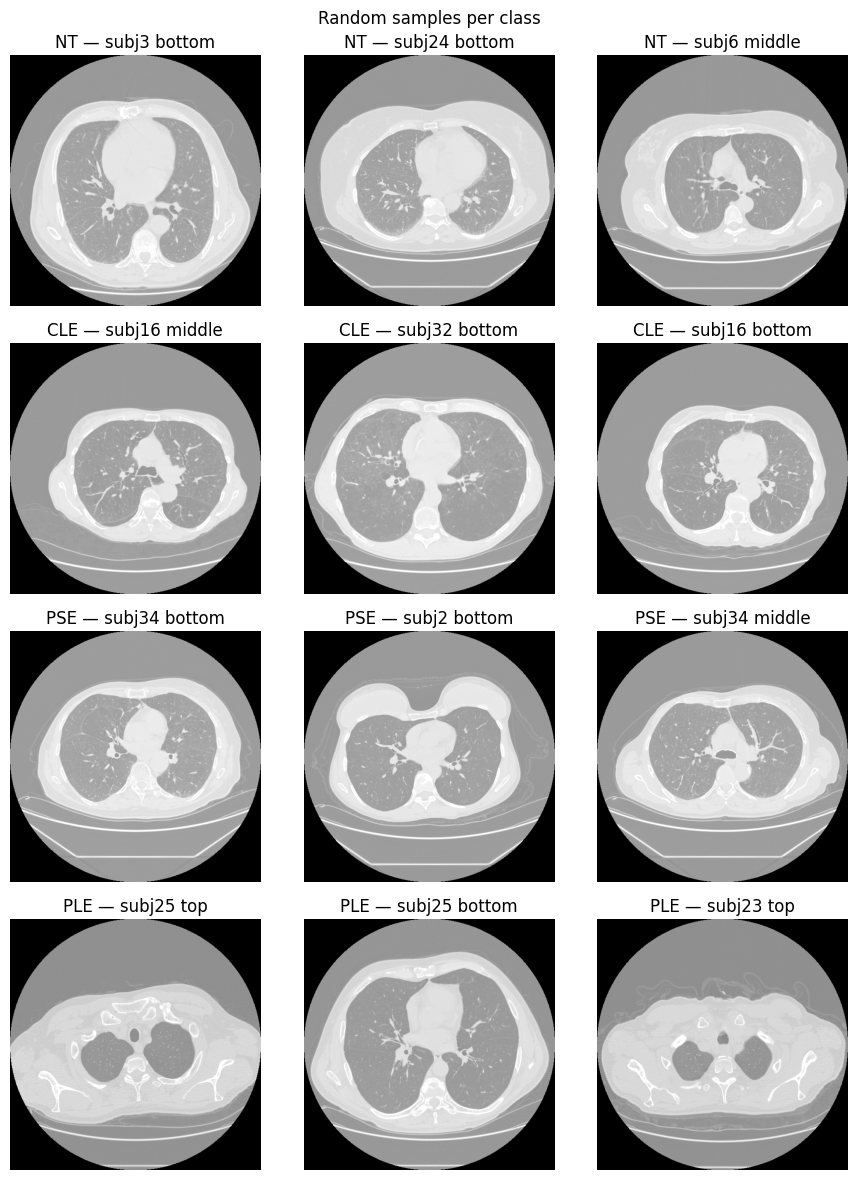

In [17]:
import random
random.seed(7)

n_per_class = 3
classes = ["NT","CLE","PSE","PLE"]

sel = []
for c in classes:
    rows = manifest[manifest["label_name"]==c]
    if len(rows) == 0:
        continue
    pick = rows.sample(min(n_per_class, len(rows)), random_state=7)
    sel.append(pick)

if len(sel) > 0:
    grid = pd.concat(sel, ignore_index=True)
    n = len(grid)
    cols = n_per_class
    rows = int(np.ceil(n/cols))

    plt.figure(figsize=(3*cols, 3*rows))
    for i, (_, r) in enumerate(grid.iterrows(), start=1):
        img = read_tiff16(r["image_path"])
        view = normalize_for_view(img)
        ax = plt.subplot(rows, cols, i)
        ax.imshow(view, cmap="gray")
        ax.set_title(f"{r['label_name']} — subj{r['subject_id']} {r['level']}")
        ax.axis("off")
    plt.suptitle("Random samples per class")
    plt.tight_layout()
    plt.show()
else:
    print("Không có đủ dữ liệu để vẽ montage.")

###  Random Samples per Class

Hình trên hiển thị **các lát CT mẫu ngẫu nhiên** từ bốn lớp mô phổi:
- **NT (Normal Tissue)** – Mô phổi bình thường, sáng hơn và đồng nhất.  
- **CLE (Centrilobular Emphysema)** – Xuất hiện các vùng giảm mật độ nhỏ rải rác ở trung tâm tiểu thùy.  
- **PSE (Paraseptal Emphysema)** – Các vùng khí tập trung dọc theo vách phổi hoặc ngoại vi.  
- **PLE (Panlobular Emphysema)** – Mật độ phổi giảm lan tỏa, toàn vùng phổi có màu tối hơn rõ rệt.

**Nhận xét:**
- Lớp **NT** thể hiện cấu trúc phổi đặc và sáng, cho thấy mật độ mô bình thường.  
- **CLE** và **PSE** có các vùng tối nhỏ xuất hiện cục bộ – dấu hiệu của khí phế thũng khu trú.  
- **PLE** có hình ảnh toàn phổi đen và ít cấu trúc – dấu hiệu emphysema lan tỏa, nặng nhất.  




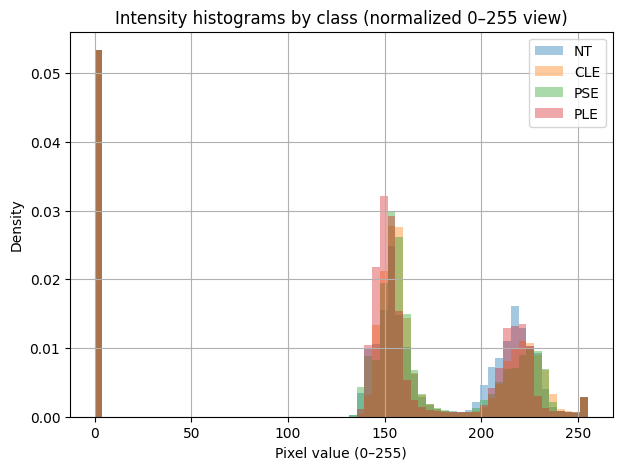

In [18]:
# Histogram cường độ (chồng lớp)
# Lấy tối đa 10 ảnh mỗi lớp 
subset_per_class = 10
bins = 64

plt.figure(figsize=(7,5))
for c in ["NT","CLE","PSE","PLE"]:
    rows = manifest[manifest["label_name"]==c].head(subset_per_class)
    if rows.empty:
        continue
    vals = []
    for p in rows["image_path"]:
        im = read_tiff16(p)
        v = normalize_for_view(im)  # dùng phiên bản view 0..255 để so histogram trực quan
        vals.append(v.flatten())
    if len(vals) == 0:
        continue
    vals = np.concatenate(vals)
    # density=True để so sánh hình dạng phân bố
    plt.hist(vals, bins=bins, alpha=0.4, density=True, label=c)
plt.title("Intensity histograms by class (normalized 0–255 view)")
plt.xlabel("Pixel value (0–255)")
plt.ylabel("Density")
plt.legend()
plt.show()


### Intensity Histograms by Class (normalized 0–255)

Biểu đồ chồng histogram thể hiện **phân bố cường độ pixel** (0–255) cho từng lớp (NT, CLE, PSE, PLE).  
Mỗi đường là **mật độ xác suất** (density=True) nên so sánh được **hình dạng phân bố** giữa các lớp dù số ảnh khác nhau.

- **Đỉnh ở ~120–170**: mô phổi chính (parenchyma).  
- **Cụm ~200–250**: cấu trúc rất sáng (xương, mạch máu, thành ngực).  
- **Cột nhỏ gần 0**: nền đen/ngoài trường nhìn.

**Nhận xét chính:**
- Phân bố của **NT** có xu hướng **dịch phải** (sáng hơn) so với các lớp bệnh lý → mô đặc hơn, ít khí.  
- **CLE/PSE/PLE** có phân bố **dịch trái** (tối hơn) và trải rộng hơn → giảm mật độ mô (nhiều khí), đặc trưng của emphysema.  
- Các đường **vẫn chồng lấn một phần** → chỉ dùng cường độ pixel **chưa đủ** để tách lớp hoàn toàn.

**Ý nghĩa:**
- Histogram xác nhận **khác biệt sáng–tối** giữa mô bình thường và mô emphysema, là cơ sở cho đặc trưng intensity.  



In [19]:
# Tính thống kê cường độ (mean/std/p1/p99) cho mỗi lớp và level
def stats_for_paths(paths):
    stats = []
    for p in paths:
        im = read_tiff16(p)
        # dùng percentile window để giảm nhiễu outlier trước khi tính mean/std
        lo, hi = np.percentile(im, 1), np.percentile(im, 99)
        im_clip = np.clip(im, lo, hi)
        stats.append({
            "mean": float(im_clip.mean()),
            "std": float(im_clip.std()),
            "p1": float(lo),
            "p99": float(hi)
        })
    return pd.DataFrame(stats)

rows = []
for (lvl, cls), df in manifest.groupby(["level","label_name"]):
    # giới hạn 20 ảnh/nhóm để nhanh
    paths = df["image_path"].head(20).tolist()
    if len(paths) == 0:
        continue
    st = stats_for_paths(paths)
    row = {
        "level": lvl,
        "label": cls,
        "mean_mean": st["mean"].mean(),
        "mean_std": st["std"].mean(),
        "mean_p1": st["p1"].mean(),
        "mean_p99": st["p99"].mean(),
        "n_images": len(paths)
    }
    rows.append(row)

stat_table = pd.DataFrame(rows).sort_values(["level","label"])
display(stat_table)


C:\Users\QUANG\AppData\Local\Temp\ipykernel_18136\1961054408.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (lvl, cls), df in manifest.groupby(["level","label_name"]):


,level,label,mean_mean,mean_std,mean_p1,mean_p99,n_images
8,bottom,CLE,-1037.177040,1109.702081,-3024.0,444.571429,7
9,bottom,NT,-1017.468896,1120.165482,-3024.0,457.550000,20
10,bottom,PLE,-1067.221548,1098.191815,-3024.0,562.000000,2
11,bottom,PSE,-1066.904768,1092.895109,-3024.0,426.250000,8
4,middle,CLE,-1042.231842,1109.509653,-3024.0,489.857143,7
5,middle,NT,-1010.835007,1125.212492,-3024.0,496.885500,20
6,middle,PLE,-1051.733585,1107.437362,-3024.0,560.500000,2
7,middle,PSE,-1063.248058,1095.975944,-3024.0,477.904444,9
0,top,CLE,-984.101146,1150.525314,-3024.0,617.571429,7
1,top,NT,-972.523389,1155.459674,-3024.0,619.378500,20


###  Intensity Statistics by Level & Class (mean/std/p1/p99)

Bảng trên tổng hợp **thống kê cường độ pixel** của từng nhóm *(level × class)*.  
Mỗi nhóm tính các chỉ số trên từng ảnh rồi **lấy trung bình**:

- **mean_mean**: độ sáng trung bình của ảnh (HU) → càng thấp → ảnh tối hơn → phổi rỗng/khí nhiều hơn.  
- **mean_std**: độ lệch chuẩn cường độ → càng cao → cấu trúc không đồng nhất hơn.  
- **mean_p1 / mean_p99**: **1st / 99th percentile** – biên dưới/trên “hợp lý” (loại bỏ outlier cực tối/sáng).  
- **n_images**: số ảnh được dùng trong nhóm.

**Nhận xét chính:**
- Ở mọi level, **NT** có **mean_mean cao hơn** (ít âm hơn) so với **CLE/PSE/PLE** → mô bình thường sáng hơn, đặc hơn.  
- **PLE** và **PSE** thường có **mean_mean thấp hơn** → giảm mật độ mô lan tỏa hoặc ven vách (đặc trưng emphysema).  
- **mean_std** khá cao (~1100 HU khi ảnh ở thang gốc) phản ánh **độ tương phản lớn** giữa các cấu trúc (khí ↔ mô ↔ xương).  
- **p1** ổn định quanh ngưỡng thấp, **p99** thay đổi theo lớp/level → mức sáng tối “hợp lý” khác nhau giữa nhóm.

**Ý nghĩa:**  
Các thống kê này cung cấp bằng chứng định lượng rằng **mô phổi bình thường (NT) khác biệt rõ về cường độ** so với các dạng emphysema.  



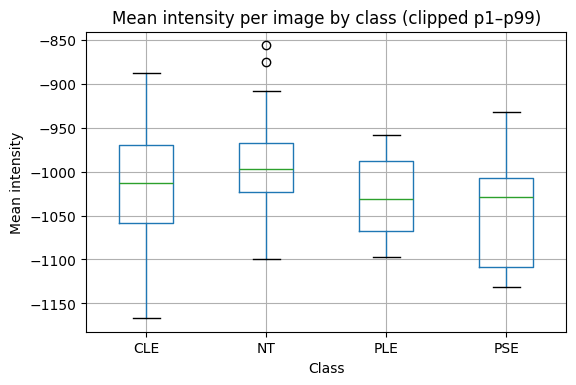

In [20]:
# Boxplot mean-intensity theo lớp (mỗi điểm = 1 ảnh)
# sử dụng mean trên ảnh đã clip p1–p99
records = []
for cls, dfc in manifest.groupby("label_name"):
    paths = dfc["image_path"].head(30).tolist()
    for p in paths:
        im = read_tiff16(p)
        lo, hi = np.percentile(im, 1), np.percentile(im, 99)
        im = np.clip(im, lo, hi)
        records.append({"label": cls, "mean_intensity": float(im.mean())})

rec = pd.DataFrame(records)
if not rec.empty:
    rec.boxplot(by="label", column=["mean_intensity"])
    plt.suptitle("")
    plt.title("Mean intensity per image by class (clipped p1–p99)")
    plt.xlabel("Class")
    plt.ylabel("Mean intensity")
    plt.show()
else:
    print("Không đủ dữ liệu để vẽ boxplot.")


###  Boxplot of Mean Intensity per Class (clipped p1–p99)

Biểu đồ hộp trên thể hiện **phân bố giá trị cường độ trung bình (mean intensity)** của các lát CT trong từng lớp: **NT, CLE, PSE, PLE**.  
Dữ liệu được **cắt biên (clip)** theo ngưỡng p1–p99 để loại bỏ outlier sáng/tối cực đoan, giúp đánh giá phân bố chính xác hơn.


- Mỗi hộp (box) biểu diễn **50% dữ liệu trung tâm** (từ Q1 đến Q3).  
- **Đường giữa hộp** là trung vị (median).  
- **Râu (whiskers)** thể hiện phạm vi cường độ chính; **các chấm tròn** là outliers.  

**Nhận xét:**
- **NT** có trung vị cao nhất (ít âm nhất, sáng hơn) → mô phổi đặc, bình thường.  
- **CLE, PSE, PLE** có trung vị thấp hơn (~ -1000 HU hoặc hơn) → mô phổi rỗng, chứa nhiều khí hơn.  
- **PLE** và **PSE** có hộp thấp và rộng hơn → phân bố cường độ trải rộng, thể hiện mức tổn thương nặng và không đồng nhất.  

 **Ý nghĩa:**  
Biểu đồ cho thấy rõ xu hướng **giảm cường độ trung bình từ NT → CLE → PSE/PLE**, phù hợp với **mức độ nghiêm trọng tăng dần của emphysema**.  
Đây là bằng chứng trực quan rằng **độ sáng trung bình của ảnh phản ánh mức độ mất mô phổi**,  
và có thể là **một đặc trưng hiệu quả cho bước huấn luyện mô hình phân loại**.


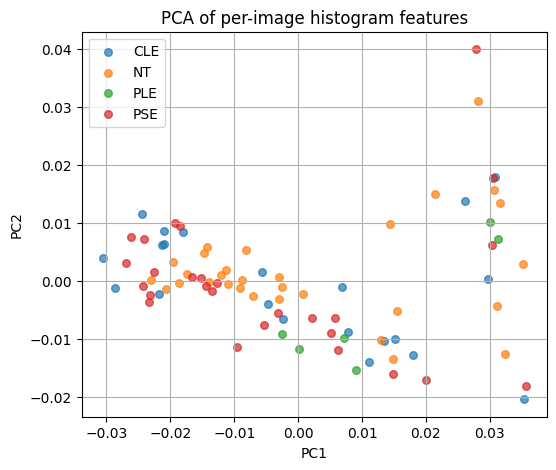

In [21]:
# PCA trên histogram 32-bin mỗi ảnh, scatter theo lớp
from sklearn.decomposition import PCA

def hist_feature(img, bins=32):
    v = normalize_for_view(img)
    h, _ = np.histogram(v, bins=bins, range=(0,255), density=True)
    return h

# Lấy tối đa 30 ảnh mỗi lớp
max_per_class = 30
X, y = [], []
for cls, group in manifest.groupby("label_name"):
    for p in group["image_path"].head(max_per_class):
        im = read_tiff16(p)
        X.append(hist_feature(im, bins=32))
        y.append(cls)

if len(X) >= 3:
    X = np.array(X)
    pca = PCA(n_components=2, random_state=7)
    Z = pca.fit_transform(X)

    plt.figure(figsize=(6,5))
    for cls in sorted(set(y)):
        idx = [i for i,t in enumerate(y) if t==cls]
        plt.scatter(Z[idx,0], Z[idx,1], label=cls, alpha=0.7, s=30)
    plt.title("PCA of per-image histogram features")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.show()
else:
    print("Không đủ mẫu để chạy PCA.")


### PCA of Per-Image Histogram Features

Biểu đồ trên thể hiện kết quả **PCA (Principal Component Analysis)** – một kỹ thuật giảm chiều dữ liệu,  
được áp dụng lên **vector histogram (32 bin)** của từng ảnh để rút gọn còn hai trục chính: **PC1** và **PC2**.  
Mỗi chấm là **một ảnh CT**, được tô màu theo lớp (**NT, CLE, PSE, PLE**).

- Các điểm nằm gần nhau → ảnh có đặc trưng cường độ tương tự.  
- Các cụm điểm tách xa nhau → các lớp có khác biệt rõ về phân bố histogram.  

**Nhận xét:**
- Các ảnh cùng lớp có xu hướng **tụ lại thành cụm nhỏ**, nhất là **NT** và **PSE**, cho thấy đặc trưng intensity của chúng khá ổn định.  
- Tuy nhiên, các lớp vẫn **chồng lấn một phần** → chỉ dựa vào histogram intensity chưa đủ để tách biệt hoàn toàn các loại emphysema.  
- Phần biến thiên chính (PC1) có thể phản ánh **mức độ sáng tối tổng thể**, trong khi PC2 thể hiện **sự biến thiên về hình dạng phân bố**.





In [28]:
# Tham số chuẩn hóa
HU_MIN, HU_MAX = -1000, 200          # Cửa sổ HU cho mô phổi
TARGET_SIZE = (512, 512)             # (width, height) cho training 2D
BACKGROUND_HU = HU_MIN               # Nền ngoài phổi = không khí

# Lưu theo .npz (không làm mất precision; tiện batch-loading & kèm mask/meta)
SAVE_EXT = ".npz"


In [29]:
import cv2
import numpy as np
import pandas as pd
from skimage import measure, morphology

def read_tiff_grayscale(path: Path) -> np.ndarray:
    """
    Đọc ảnh Grayscale (TIFF/PNG...). Trả về float32.
    """
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(path)
    return img.astype(np.float32)

def hu_window(img_hu: np.ndarray, hu_min: int = HU_MIN, hu_max: int = HU_MAX) -> np.ndarray:
    """
    Áp cửa sổ HU, giữ giá trị float32 trong [hu_min, hu_max].
    """
    return np.clip(img_hu, hu_min, hu_max).astype(np.float32)

def to_unit_range(img_win: np.ndarray, hu_min: int = HU_MIN, hu_max: int = HU_MAX) -> np.ndarray:
    """
    Chuẩn hóa ảnh windowed về [0,1] (float32).
    """
    img = (img_win - hu_min) / float(hu_max - hu_min)
    return np.clip(img, 0.0, 1.0).astype(np.float32)


In [30]:
def adaptive_lung_threshold(img_hu, lo=-400, hi=-260):
    torso = img_hu > -800                      # lọc nền ngoài cơ thể
    vals = img_hu[torso].astype(np.float32)
    hist, bins = np.histogram(vals, bins=512)
    thr = bins[np.argmax(hist.cumsum() > hist.sum()/2)]  # proxy nhanh
    thr = np.clip(thr, lo, hi)
    return float(thr)


In [31]:
def largest_two_components(mask: np.ndarray) -> np.ndarray:
    labels = measure.label(mask, connectivity=2)
    if labels.max() == 0:
        return np.zeros_like(mask, dtype=bool)
    regs = measure.regionprops(labels)
    areas = sorted(((r.label, r.area) for r in regs), key=lambda x: x[1], reverse=True)
    keep = [lab for lab, _ in areas[:2]]
    return np.isin(labels, keep)

def segment_lungs_hu(img_hu: np.ndarray) -> np.ndarray:
    """
    1) Ngưỡng < -320 HU để bắt không khí (phổi + nền ngoài)
    2) Loại bỏ thành phần dính biên (không khí ngoài cơ thể)
    3) Giữ 2 thành phần lớn nhất (hai lá phổi)
    4) Làm mịn mask bằng morphology
    """
    thr = adaptive_lung_threshold(img_hu)  
    air_mask = img_hu < thr


    # loại background ngoài cơ thể (thành phần dính biên)
    labels = measure.label(air_mask, connectivity=2)
    h, w = air_mask.shape
    border = np.zeros_like(air_mask, dtype=bool)
    border[0, :]=True; border[-1, :]=True; border[:, 0]=True; border[:, -1]=True
    border_labels = np.unique(labels[border])
    inside_mask = ~np.isin(labels, border_labels) & (labels > 0)

    lung = largest_two_components(inside_mask)
    lung = morphology.binary_closing(lung, morphology.disk(4))
    lung = morphology.binary_opening(lung, morphology.disk(2))
    lung = morphology.remove_small_holes(lung, area_threshold=1500)
    lung = morphology.remove_small_objects(lung, min_size=1500)
    return lung.astype(bool)


In [32]:
def qc_flags(img_win_r, lung_mask_r):
    """
    QC trên ảnh đã window [-1000,200] và đã resize.
    Trả về: dict gồm area_ratio, laa, touch_edge, bad.
    """
    h, w = lung_mask_r.shape
    area_ratio = float(lung_mask_r.mean())  # tỉ lệ phổi trong khung
    touch_edge = bool(
        lung_mask_r[0,:].any() or lung_mask_r[-1,:].any() or
        lung_mask_r[:,0].any() or lung_mask_r[:,-1].any()
    )
    laa = float((img_win_r[lung_mask_r] < -950).mean()) if lung_mask_r.any() else 0.0

    # Ngưỡng kinh nghiệm cho lát 2D đã crop+resize:
    bad_area = not (0.12 <= area_ratio <= 0.60)
    bad_laa  = not (0.00 <= laa <= 0.60)

    return dict(area_ratio=area_ratio, laa=laa, touch_edge=touch_edge,
                qc_bad=bool(bad_area or bad_laa or touch_edge))


In [33]:
def preprocess_one_image(img_path: Path,
                         out_dir: Path,
                         target_size=TARGET_SIZE,
                         save_ext=SAVE_EXT):
    """
    Lưu .npz gồm:
      - img_norm: float32 [H,W] ∈ [0,1] (sau window [-1000,200] & normalize)
      - img_win:  float32 [H,W] ∈ [HU_MIN,HU_MAX] (để dùng ngưỡng -950 HU khi cần)
      - lung_mask: bool [H,W]
      - meta: dict tối giản (dùng np.savez -> lưu dạng mảng object)
    Trả về đường dẫn và thống kê.
    """
    img_hu = read_tiff_grayscale(img_path)

    # mask phổi
    lung_mask = segment_lungs_hu(img_hu)

    # đặt ngoài phổi = HU_MIN (không khí) để không ảnh hưởng window/normalize
    img_masked = img_hu.copy()
    img_masked[~lung_mask] = BACKGROUND_HU

    # window HU và chuẩn hóa
    img_win = hu_window(img_masked, HU_MIN, HU_MAX)      # giữ HU trong cửa sổ
    img_norm = to_unit_range(img_win, HU_MIN, HU_MAX)    # [0,1]

    # cắt theo bbox phổi để tăng tỷ lệ thông tin
    ys, xs = np.where(lung_mask)
    if len(xs) > 0 and len(ys) > 0:
        pad = 16
        x0, x1 = max(0, xs.min()-pad), min(img_norm.shape[1]-1, xs.max()+pad)
        y0, y1 = max(0, ys.min()-pad), min(img_norm.shape[0]-1, ys.max()+pad)

        img_norm = img_norm[y0:y1+1, x0:x1+1]
        img_win  = img_win [y0:y1+1, x0:x1+1]
        lung_mask = lung_mask[y0:y1+1, x0:x1+1]
        bbox = (int(x0), int(y0), int(x1), int(y1))
    else:
        bbox = (0, 0, int(img_norm.shape[1]-1), int(img_norm.shape[0]-1))

    # resize thống nhất
    img_norm_r = cv2.resize(img_norm, target_size, interpolation=cv2.INTER_AREA).astype(np.float32)
    img_win_r  = cv2.resize(img_win,  target_size, interpolation=cv2.INTER_AREA).astype(np.float32)
    lung_mask_r= cv2.resize(lung_mask.astype(np.uint8), target_size, interpolation=cv2.INTER_NEAREST) > 0

    # lưu .npz (nén)
    out_path = out_dir / (img_path.stem + save_ext)
    meta = {
        "orig_h": int(img_hu.shape[0]),
        "orig_w": int(img_hu.shape[1]),
        "bbox_xyxy": bbox,
        "hu_min": int(HU_MIN),
        "hu_max": int(HU_MAX),
        "target_w": int(target_size[0]),
        "target_h": int(target_size[1]),
        "source": img_path.as_posix()
    }
    # np.savez_compressed không lưu dict trực tiếp; ta chuyển sang object ndarray
    np.savez_compressed(out_path,
                        img_norm=img_norm_r.astype(np.float32),
                        img_win=img_win_r.astype(np.float32),
                        lung_mask=lung_mask_r.astype(np.bool_),
                        meta=np.array(meta, dtype=object))

    # --- QC sau khi resize ---
    qc = qc_flags(img_win_r, lung_mask_r)
    
    # thống kê
    lung_area = int(lung_mask_r.sum())
    lung_ratio = float(lung_area) / float(lung_mask_r.size)
    stats = {
        "lung_area_px": lung_area,
        "lung_ratio": lung_ratio,
        "hu_min_in_mask": float(img_win_r[lung_mask_r].min()) if lung_area > 0 else np.nan,
        "hu_max_in_mask": float(img_win_r[lung_mask_r].max()) if lung_area > 0 else np.nan,
        **qc, 
    }

    
    
    return out_path, stats


In [34]:
from tqdm import tqdm

manifest = pd.read_csv(MANIFEST_IN)
print("Số dòng manifest gốc:", len(manifest))

records, errors = [], []

for _, row in tqdm(manifest.iterrows(), total=len(manifest)):
    try:
        img_path = Path(row["image_path"])
        out_path, stats = preprocess_one_image(
            img_path, OUT_IMG,
            target_size=TARGET_SIZE,
            save_ext=SAVE_EXT
        )

        rec = dict(row)
        rec["preprocessed_path"] = out_path.as_posix()
        rec.update(stats)                      # <<<< gồm cả các trường QC
        records.append(rec)

    except Exception as e:
        errors.append((row.get("slice_key", "?"), img_path.as_posix(), str(e)))

df_out = pd.DataFrame(records)

# 1) Lưu manifest đầy đủ (có QC)
df_out.to_csv(MANIFEST_OUT, index=False)
print(f"Đã xử lý: {len(df_out)}/{len(manifest)} ảnh -> {MANIFEST_OUT.as_posix()}")

# 2) Báo cáo QC: tách lát bị gắn cờ
qc_bad = df_out[df_out.get("qc_bad", False) == True].copy()
qc_good = df_out[df_out.get("qc_bad", False) == False].copy()

QC_REPORT = OUT / "qc_report.csv"
qc_bad.to_csv(QC_REPORT, index=False)

print(f"QC: {len(qc_bad)} lát bị gắn cờ / {len(df_out)} tổng số. Báo cáo: {QC_REPORT.as_posix()}")

if not qc_bad.empty:
    print("Một số lát QC xấu :")
    display(qc_bad[["slice_key","preprocessed_path","area_ratio","laa","touch_edge"]].head(5))

# 3) Tạo manifest 'sạch' để train (lọc qc_bad==False)
MANIFEST_TRAIN = OUT / "manifest_slices_preprocessed_clean.csv"
df_clean = qc_good.reset_index(drop=True)
df_clean.to_csv(MANIFEST_TRAIN, index=False)
print("Manifest sạch để train:", MANIFEST_TRAIN.as_posix(),
      f"({len(df_clean)} mẫu, loại {len(qc_bad)} mẫu)")

#  Thống kê theo lớp (nếu có cột 'label_name' hoặc 'label_code')
if "label_name" in df_out.columns:
    print("\nPhân bố lớp (sau lọc QC):")
    display(df_clean["label_name"].value_counts().to_frame("count"))
elif "label_code" in df_out.columns:
    print("\nPhân bố lớp (sau lọc QC):")
    display(df_clean["label_code"].value_counts().to_frame("count"))

# Xử lý lỗi
if errors:
    print("\nMột số lỗi :")
    for sk, p, msg in errors[:10]:
        print(f"- {sk}: {p} -> {msg}")


Số dòng manifest gốc: 115


100%|████████████████████████████████████████████████████████████████████████████████| 115/115 [00:09<00:00, 11.90it/s]

Đã xử lý: 115/115 ảnh -> Data/processed/sorensen/manifest_slices_preprocessed.csv
QC: 0 lát bị gắn cờ / 115 tổng số. Báo cáo: Data/processed/emphysema_merged/qc_report.csv
Manifest sạch để train: Data/processed/emphysema_merged/manifest_slices_preprocessed_clean.csv (115 mẫu, loại 0 mẫu)

Phân bố lớp (sau lọc QC):


,count
label_name,
NT,61
PSE,27
CLE,21
PLE,6


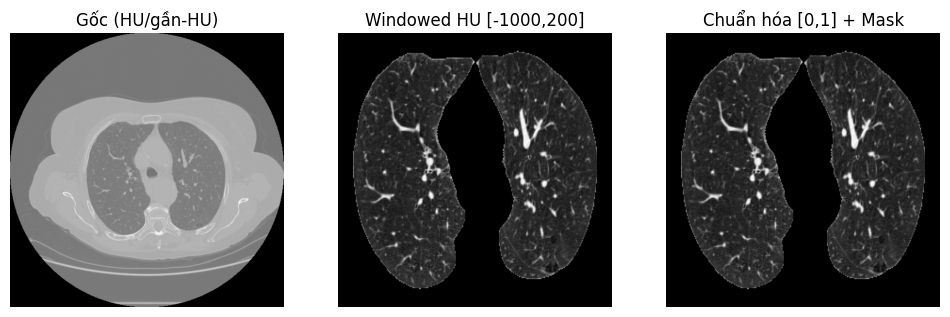

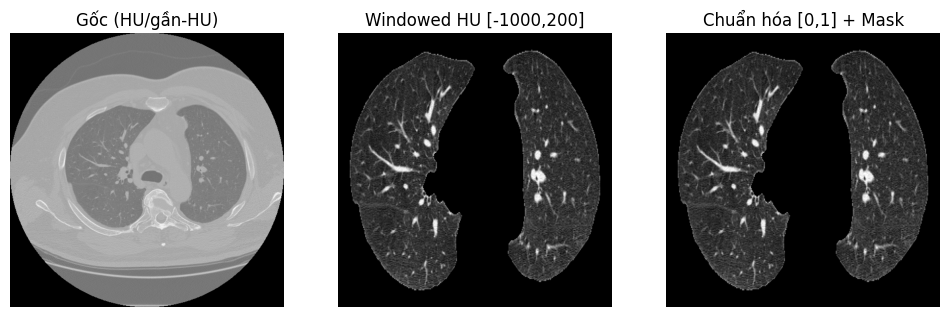

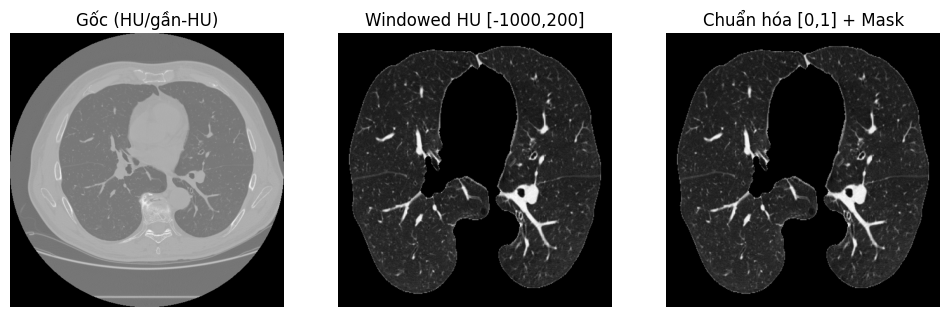

In [35]:
import random
import matplotlib.pyplot as plt

def load_npz(npz_path: str):
    z = np.load(npz_path, allow_pickle=True)
    return z["img_norm"], z["img_win"], z["lung_mask"], z["meta"].item()

def show_pair(raw_path: str, npz_path: str):
    raw = read_tiff_grayscale(Path(raw_path))
    img_norm, img_win, lung_mask, meta = load_npz(npz_path)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(raw, cmap="gray"); plt.title("Gốc (HU/gần-HU)"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(img_win, cmap="gray"); plt.title("Windowed HU [-1000,200]"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(img_norm, cmap="gray"); plt.title("Chuẩn hóa [0,1] + Mask"); plt.axis("off")
    plt.show()

# Lấy mẫu ngẫu nhiên để kiểm tra
if len(df_out):
    sample = df_out.sample(min(3, len(df_out)), random_state=42)
    for _, r in sample.iterrows():
        show_pair(r["image_path"], r["preprocessed_path"])


In [36]:

import pandas as pd
from pathlib import Path

# DATA_ROOT   = Path("Data")
# OUT         = DATA_ROOT / "processed" / "sorensen"
# MANIFEST_CLEAN = OUT / "manifest_slices_preprocessed_clean.csv" 
DATA_ROOT = Path("Data")
OUT = DATA_ROOT / "processed" / "emphysema_merged"

MANIFEST_CLEAN = Path("Data/processed/emphysema_all/manifest_emphysema_all.csv")
df = pd.read_csv(MANIFEST_CLEAN)



df = pd.read_csv(MANIFEST_CLEAN)
# Chỉ giữ các cột cần thiết
cols_keep = ["slice_key","subject_id","label_name","label_code","preprocessed_path"]
df = df[cols_keep].copy()
df.head()

,slice_key,subject_id,label_name,label_code,preprocessed_path
0,subject24_top,24,NT,1,Data/processed/sorensen/preprocessed/subject24...
1,subject24_middle,24,NT,1,Data/processed/sorensen/preprocessed/subject24...
2,subject24_bottom,24,NT,1,Data/processed/sorensen/preprocessed/subject24...
3,subject9_top,9,NT,1,Data/processed/sorensen/preprocessed/subject9_...
4,subject9_middle,9,NT,1,Data/processed/sorensen/preprocessed/subject9_...


In [37]:
# 2) Split theo subject (grouped) + stratified theo label
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold

# ---- 0) Cột định danh file/slice dùng để so khớp loại trừ ----
PATH_COL = (
    "image_path" if "image_path" in df.columns
    else ("preprocessed_path" if "preprocessed_path" in df.columns
          else ("slice_key" if "slice_key" in df.columns else None))
)
if PATH_COL is None:
    raise ValueError("Không tìm thấy cột định danh (image_path / preprocessed_path / slice_key) trong df.")

# ---- 1) Thứ tự classes (nếu chưa có) ----
try:
    classes
except NameError:
    classes = ["NT","CLE","PSE","PLE"] if {"NT","CLE","PSE","PLE"}.issubset(set(df["label_name"].unique())) \
              else sorted(df["label_name"].unique().tolist())

# ---- 2) Major label theo subject để stratify ----
subject_stats = df.groupby(["subject_id","label_name"]).size().unstack(fill_value=0)
major_label   = subject_stats.idxmax(axis=1)
sub2label     = major_label.to_dict()

# Các subject có PLE và số slice PLE theo subject
ple_subj         = subject_stats.index[subject_stats.get("PLE", 0) > 0].tolist()
ple_cnt_by_subj  = subject_stats.get("PLE", 0)

# ---- 3) Helpers ----
def safe_n_splits(labels, desired, min_allowed=2):
    """Giảm n_splits không vượt quá số lượng lớp ít nhất."""
    vc = pd.Series(labels).value_counts()
    return max(min_allowed, min(desired, int(vc.min())))

def _move_subject(src, dst, sid):
    rows = src[src["subject_id"]==sid]
    src  = src[src["subject_id"]!=sid].reset_index(drop=True)
    dst  = pd.concat([dst, rows], ignore_index=True)
    return src, dst

def _save_and_report(train_df, val_df, test_df):
    print("Số lượng:", { "train": len(train_df), "val": len(val_df), "test": len(test_df) })
    print("Số subject:", {
        "train": train_df["subject_id"].nunique(),
        "val":   val_df["subject_id"].nunique(),
        "test":  test_df["subject_id"].nunique()
    })
    # Lưu CSV chia tập
    SPLIT_DIR = OUT / "splits"
    SPLIT_DIR.mkdir(parents=True, exist_ok=True)
    train_df.to_csv(SPLIT_DIR / "train.csv", index=False)
    val_df.to_csv(SPLIT_DIR / "val.csv", index=False)
    test_df.to_csv(SPLIT_DIR / "test.csv", index=False)
    # Phân bố lớp
    print("\nPhân bố lớp (train):")
    display(train_df["label_name"].value_counts().reindex(classes, fill_value=0).to_frame("count"))
    print("\nPhân bố lớp (val):")
    display(val_df["label_name"].value_counts().reindex(classes, fill_value=0).to_frame("count"))
    print("\nPhân bố lớp (test):")
    display(test_df["label_name"].value_counts().reindex(classes, fill_value=0).to_frame("count"))

# =========================
# CASE A: >= 3 PLE subjects
# =========================
groups  = df["subject_id"].values
y_major = df["subject_id"].map(sub2label).values

if len(ple_subj) >= 3:
    n_splits1 = safe_n_splits(y_major, desired=5, min_allowed=2)
    sgkf = StratifiedGroupKFold(n_splits=n_splits1, shuffle=True, random_state=42)
    fold_pairs = list(sgkf.split(df, y=y_major, groups=groups))

    test_idx   = fold_pairs[0][1]
    remain_idx = fold_pairs[0][0]
    df_remain  = df.iloc[remain_idx].copy()

    groups_r  = df_remain["subject_id"].values
    y_major_r = df_remain["subject_id"].map(sub2label).values
    n_splits2 = safe_n_splits(y_major_r, desired=4, min_allowed=2)

    sgkf2     = StratifiedGroupKFold(n_splits=n_splits2, shuffle=True, random_state=7)
    val_idx_r, train_idx_r = list(sgkf2.split(df_remain, y=y_major_r, groups=groups_r))[0][1], \
                             list(sgkf2.split(df_remain, y=y_major_r, groups=groups_r))[0][0]

    train_df = df_remain.iloc[train_idx_r].reset_index(drop=True)
    val_df   = df_remain.iloc[val_idx_r].reset_index(drop=True)
    test_df  = df.iloc[test_idx].reset_index(drop=True)

    # Sửa sau chia để đảm bảo mỗi tập có đủ lớp
    subj_cls = df.groupby(["subject_id","label_name"]).size().unstack(fill_value=0)

    # Ưu tiên TEST rồi VAL
    for cls in classes:
        if cls not in test_df["label_name"].unique():
            cands = (subj_cls[subj_cls[cls]>0][cls].sort_values(ascending=False).index.tolist())
            cands = [sid for sid in cands if sid in set(train_df["subject_id"].unique())]
            if cands:
                train_df, test_df = _move_subject(train_df, test_df, cands[0])
    for cls in classes:
        if cls not in val_df["label_name"].unique():
            cands = (subj_cls[subj_cls[cls]>0][cls].sort_values(ascending=False).index.tolist())
            cands = [sid for sid in cands if sid in set(train_df["subject_id"].unique())]
            if cands:
                train_df, val_df = _move_subject(train_df, val_df, cands[0])

    # Loại trùng subject
    s_test = set(test_df["subject_id"].unique())
    s_val  = set(val_df["subject_id"].unique())
    train_df = train_df[~train_df["subject_id"].isin(s_test | s_val)].reset_index(drop=True)
    val_df   = val_df[~val_df["subject_id"].isin(s_test)].reset_index(drop=True)

    print(f"Mode: regular (>=3 PLE subjects). PATH_COL={PATH_COL}")
    _save_and_report(train_df, val_df, test_df)

# =========================
# CASE B: chỉ có 2 PLE subjects
# =========================
else:
    print(f"Mode: SPECIAL (only 2 PLE subjects). PATH_COL={PATH_COL}")

    # Chọn subject PLE có ít slice hơn cho TEST để giữ nhiều PLE cho train/val
    ple_subj_sorted = sorted(ple_subj, key=lambda s: int(ple_cnt_by_subj.loc[s]))
    ple_test_sid, ple_train_sid = ple_subj_sorted[0], ple_subj_sorted[1]

    # 1) TEST: trọn subject ple_test_sid + thêm fold từ phần còn lại
    test_df_ple = df[df["subject_id"]==ple_test_sid]
    df_non_test = df[df["subject_id"]!=ple_test_sid].reset_index(drop=True)

    groups_nt  = df_non_test["subject_id"].values
    y_major_nt = df_non_test["subject_id"].map(sub2label).values
    n_splits_nt = safe_n_splits(y_major_nt, desired=5, min_allowed=2)
    sgkf = StratifiedGroupKFold(n_splits=n_splits_nt, shuffle=True, random_state=42)
    folds = list(sgkf.split(df_non_test, y=y_major_nt, groups=groups_nt))
    extra_test_idx = folds[0][1]

    test_df_rest = df_non_test.iloc[extra_test_idx].reset_index(drop=True)
    test_df      = pd.concat([test_df_ple, test_df_rest], ignore_index=True)

    # 2) Pool còn lại cho TRAIN/VAL (loại bỏ các hàng đã vào TEST theo PATH_COL)
    df_pool = df[~df[PATH_COL].isin(test_df[PATH_COL])].reset_index(drop=True)

    # 3) Với subject PLE còn lại: CHIA THEO SLICE cho VAL (>=1) và giữ LẠI >=1 cho TRAIN nếu có thể
    pool_ple  = df_pool[df_pool["subject_id"]==ple_train_sid].reset_index(drop=True)
    pool_rest = df_pool[df_pool["subject_id"]!=ple_train_sid].reset_index(drop=True)

    # số slice PLE còn lại (chỉ 1 subject)
    n_ple_total = len(pool_ple)
    # chọn số slice cho VAL: tối thiểu 1, tối đa n_ple_total-1 (để còn lại >=1 cho TRAIN nếu n_ple_total>1)
    n_val_ple = 1 if n_ple_total >= 1 else 0
    if n_ple_total > 1:
        n_val_ple = min(max(1, int(round(n_ple_total * 0.15))), n_ple_total - 1)
    # (nếu chỉ có đúng 1 slice thì val = 1, train = 0 – trường hợp bất khả kháng)

    if n_val_ple > 0:
        rng = np.random.RandomState(123)
        val_ple_idx = rng.choice(n_ple_total, size=n_val_ple, replace=False)
        val_ple_df  = pool_ple.iloc[val_ple_idx]
        train_ple_df= pool_ple.drop(pool_ple.index[val_ple_idx])
    else:
        val_ple_df  = pool_ple.iloc[:0]
        train_ple_df= pool_ple.copy()

    # 4) Non-PLE: chia theo subject cho TRAIN/VAL
    groups_r  = pool_rest["subject_id"].values
    y_major_r = pool_rest["subject_id"].map(sub2label).values
    n_splits2 = safe_n_splits(y_major_r, desired=4, min_allowed=2)
    sgkf2     = StratifiedGroupKFold(n_splits=n_splits2, shuffle=True, random_state=7)
    _split    = list(sgkf2.split(pool_rest, y=y_major_r, groups=groups_r))[0]
    val_idx_r, train_idx_r = _split[1], _split[0]

    val_rest_df   = pool_rest.iloc[val_idx_r].reset_index(drop=True)
    train_rest_df = pool_rest.iloc[train_idx_r].reset_index(drop=True)

    # GHÉP: cho phép trùng subject ple_train_sid giữa TRAIN và VAL (slice-level split)
    val_df   = pd.concat([val_rest_df,   val_ple_df],   ignore_index=True)
    train_df = pd.concat([train_rest_df, train_ple_df], ignore_index=True)

    # Loại trùng subject với TEST (đảm bảo disjoint theo subject so với TEST)
    s_test = set(test_df["subject_id"].unique())
    train_df = train_df[~train_df["subject_id"].isin(s_test)].reset_index(drop=True)
    val_df   = val_df[~val_df["subject_id"].isin(s_test)].reset_index(drop=True)

    # KHÔNG loại trùng subject giữa TRAIN và VAL đối với ple_train_sid (cho phép overlap slice-level)
    # Nếu có subject trùng khác ngoài ple_train_sid (hiếm), loại khỏi TRAIN để tránh leakage
    overlap = (set(train_df["subject_id"].unique()) & set(val_df["subject_id"].unique())) - {ple_train_sid}
    if overlap:
        train_df = train_df[~train_df["subject_id"].isin(overlap)].reset_index(drop=True)

    # Cảnh báo leakage ở VAL do lấy slice từ subject PLE còn lại
    print(f"WARNING: VAL chứa {(val_df['label_name']=='PLE').sum()} slice PLE từ subject {ple_train_sid}. "
          "Chỉ dùng VAL cho early-stopping; đánh giá tổng quát PLE dựa trên TEST.")

    _save_and_report(train_df, val_df, test_df)


Mode: regular (>=3 PLE subjects). PATH_COL=preprocessed_path
Số lượng: {'train': 95, 'val': 38, 'test': 28}
Số subject: {'train': 51, 'val': 18, 'test': 16}

Phân bố lớp (train):


,count
label_name,
NT,35
CLE,26
PSE,20
PLE,14



Phân bố lớp (val):


,count
label_name,
NT,21
CLE,12
PSE,2
PLE,3



Phân bố lớp (test):


,count
label_name,
NT,5
CLE,5
PSE,15
PLE,3


In [38]:
# 3) Class weights theo phân bố train
from collections import Counter

classes = ["NT","CLE","PSE","PLE"]  
cnt = Counter(train_df["label_name"])
N = sum(cnt.values()); K = len(classes)
class_weights = {c: (N / (K * cnt.get(c,1))) for c in classes}
class_weights


{'NT': 0.6785714285714286,
 'CLE': 0.9134615384615384,
 'PSE': 1.1875,
 'PLE': 1.6964285714285714}

In [45]:
#import sys
#!"{sys.executable}" -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


In [46]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


PyTorch version: 2.5.1+cu121
CUDA available: True


In [39]:
# 4) Dataset + Augmentation
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A

label2id = {c:i for i,c in enumerate(classes)}

train_tfms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05,
                       rotate_limit=8, border_mode=0, value=0, p=0.5),
    A.ElasticTransform(alpha=10, sigma=10*0.05, alpha_affine=5,
                       border_mode=0, value=0, p=0.15),
], p=1.0)

val_tfms = A.Compose([], p=1.0)

class SorensenNPZDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        z = np.load(row["preprocessed_path"], allow_pickle=True)
        img = z["img_norm"].astype(np.float32)  # [H,W] in [0,1]
        

        # Albumentations nhận HxWxc -> thêm kênh giả
        img3 = np.expand_dims(img, axis=2)
        if self.transforms is not None:
            img3 = self.transforms(image=img3)["image"]
        img = img3[...,0]  # quay lại HxW

        # To tensor (1,H,W)
        x = torch.from_numpy(img).unsqueeze(0)        # 1 channel
        y = torch.tensor(label2id[row["label_name"]], dtype=torch.long)
        return x, y


In [40]:
# 5) DataLoader
import os
BATCH_SIZE = 8
NUM_WORKERS = 0  # max(0, min(4, os.cpu_count() // 2))

train_ds = SorensenNPZDataset(train_df, transforms=train_tfms)
val_ds   = SorensenNPZDataset(val_df,   transforms=val_tfms)
test_ds  = SorensenNPZDataset(test_df,  transforms=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

# Class weights tensor cho CrossEntropy
weights_tensor = torch.tensor([class_weights[c] for c in classes], dtype=torch.float32)
weights_tensor


tensor([0.6786, 0.9135, 1.1875, 1.6964])

In [41]:
import numpy as np
import torch
from collections import Counter
import pandas as pd

def summarize_augmented(loader, classes, num_batches=50):
    """
    Duyệt num_batches từ DataLoader (đã có augment) và in thống kê tóm tắt.
    """
    pix_vals = []
    labels   = []

    it = iter(loader)
    for _ in range(min(num_batches, len(loader))):
        try:
            x, y = next(it)   # x: [B,1,H,W] đã augment; y: [B]
        except StopIteration:
            break
        x = x.cpu().numpy()
        y = y.cpu().numpy()
        labels.extend(y.tolist())
        pix_vals.append(x.reshape(-1))  # gom toàn bộ pixel

    if not labels:
        print("Loader rỗng?")
        return

    pix_vals = np.concatenate(pix_vals, axis=0)
    label_cnt = Counter(labels)

    # Summary pixel
    mean = float(pix_vals.mean())
    std  = float(pix_vals.std())
    vmin = float(pix_vals.min())
    vmax = float(pix_vals.max())
    p1, p50, p95, p99 = np.percentile(pix_vals, [1,50,95,99])
    zero_ratio = float((pix_vals == 0).mean())

    # In kết quả
    print(f"Số batch quét: {min(num_batches, len(loader))}")
    print(f"Số mẫu (ước tính): {sum(label_cnt.values())}")
    print("\nPhân bố lớp (sau augment online, nhãn không đổi):")
    dist = pd.DataFrame({
        "class": [classes[i] for i in range(len(classes))],
        "count": [label_cnt.get(i, 0) for i in range(len(classes))]
    }).set_index("class")
    display(dist)

    print("\nTóm tắt pixel (sau augment):")
    print(f"mean={mean:.4f} | std={std:.4f} | min={vmin:.4f} | max={vmax:.4f}")
    print(f"p1={p1:.4f} | p50={p50:.4f} | p95={p95:.4f} | p99={p99:.4f}")
    print(f"tỉ lệ pixel =0 (nền/ngoài phổi): {zero_ratio:.3f}")

# Gọi hàm: (quét 50 batch đầu của train_loader)
summarize_augmented(train_loader, classes=classes, num_batches=50)


Số batch quét: 12
Số mẫu (ước tính): 95

Phân bố lớp (sau augment online, nhãn không đổi):


,count
class,
NT,35
CLE,26
PSE,20
PLE,14



Tóm tắt pixel (sau augment):
mean=0.2006 | std=0.2736 | min=0.0000 | max=1.0000
p1=0.0000 | p50=0.1392 | p95=0.9525 | p99=1.0000
tỉ lệ pixel =0 (nền/ngoài phổi): 0.403


In [42]:
#import sys
#!"{sys.executable}" -m pip install torchinfo
      

In [43]:
# Model
import torch, torch.nn as nn, torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        return x

class EmphysemaCNN(nn.Module):
    def __init__(self, num_classes=4, in_ch=1):
        super().__init__()
        self.b1 = ConvBlock(in_ch, 32);  self.p1 = nn.MaxPool2d(2)  # 512->256
        self.b2 = ConvBlock(32, 64);     self.p2 = nn.MaxPool2d(2)  # 256->128
        self.b3 = ConvBlock(64, 128);    self.p3 = nn.MaxPool2d(2)  # 128->64
        self.b4 = ConvBlock(128, 256);   self.p4 = nn.MaxPool2d(2)  # 64->32
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.30),
            nn.Linear(256, 128), nn.ReLU(inplace=True),
            nn.Dropout(0.30),
            nn.Linear(128, len(classes))
        )
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

    def forward(self, x):
        x = self.p1(self.b1(x))
        x = self.p2(self.b2(x))
        x = self.p3(self.b3(x))
        x = self.p4(self.b4(x))
        x = self.gap(x)
        x = self.head(x)      # logits
        return x

model = EmphysemaCNN(num_classes=len(classes), in_ch=1).to(device)


from torchinfo import summary

summary(model, input_size=(1, 1, 512, 512),  # (batch, channel, H, W)
        col_names=("input_size","output_size","num_params","kernel_size","mult_adds"),
        depth=3)  # chỉnh độ sâu in ra



Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
EmphysemaCNN                             [1, 1, 512, 512]          [1, 4]                    --                        --                        --
├─ConvBlock: 1-1                         [1, 1, 512, 512]          [1, 32, 512, 512]         --                        --                        --
│    └─Conv2d: 2-1                       [1, 1, 512, 512]          [1, 32, 512, 512]         288                       [3, 3]                    75,497,472
│    └─BatchNorm2d: 2-2                  [1, 32, 512, 512]         [1, 32, 512, 512]         64                        --                        64
│    └─Conv2d: 2-3                       [1, 32, 512, 512]         [1, 32, 512, 512]         9,216                     [3, 3]                    2,415,919,104
│    └─BatchNorm2d: 2-4                  [1, 32, 512, 512]         [1, 32, 512, 512]  

In [44]:
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn

USE_FOCAL = False
EARLYSTOP_METRIC = "auc"   # "auc" hoặc "f1"

if USE_FOCAL:
    class FocalLoss(nn.Module):
        def __init__(self, alpha=None, gamma=2.0):
            super().__init__()
            self.alpha = alpha
            self.gamma = gamma
        def forward(self, logits, target):
            ce = F.cross_entropy(logits, target, weight=self.alpha, reduction="none")
            pt = torch.exp(-ce)
            return ((1-pt)**self.gamma * ce).mean()
    criterion = FocalLoss(alpha=weights_tensor.to(device), gamma=2.0)
else:
    criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device), label_smoothing=0.05)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

class EarlyStopper:
    def __init__(self, patience=7, mode="max", delta=1e-4):
        self.patience = patience; self.mode = mode; self.delta = delta
        self.best = -float("inf") if mode=="max" else float("inf")
        self.num_bad = 0; self.stop = False
    def step(self, score):
        improved = (score > self.best + self.delta) if self.mode=="max" else (score < self.best - self.delta)
        if improved:
            self.best = score; self.num_bad = 0; return True
        else:
            self.num_bad += 1
            self.stop = self.num_bad >= self.patience
            return False

early = EarlyStopper(patience=7, mode="max", delta=1e-4)


In [45]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

@torch.no_grad()
def evaluate(loader, model, criterion, device, classes):
    model.eval()
    tot_loss, n = 0.0, 0
    probs_all, y_all = [], []

    for x, y in loader:
        x = x.to(device); y = y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        tot_loss += loss.item() * x.size(0); n += x.size(0)
        probs_all.append(logits.softmax(1).cpu().numpy())
        y_all.append(y.cpu().numpy())

    y_true = np.concatenate(y_all)
    y_prob = np.concatenate(probs_all, axis=0)
    y_pred = y_prob.argmax(1)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")

    # AUC OvR theo lớp khả dụng (không NaN)
    per_class_auc, auc_vals = {}, []
    C = len(classes)
    for i, cls in enumerate(classes):
        y_bin = (y_true == i).astype(int)
        if y_bin.min() == y_bin.max():  # thiếu lớp i ở tập này
            per_class_auc[cls] = np.nan
        else:
            auc_i = roc_auc_score(y_bin, y_prob[:, i])
            per_class_auc[cls] = float(auc_i); auc_vals.append(auc_i)
    macro_auc = float(np.mean(auc_vals)) if len(auc_vals) > 0 else np.nan

    return {
        "loss": tot_loss / max(n, 1),
        "acc": acc,
        "f1": f1,
        "auc": macro_auc,
        "per_class_auc": per_class_auc
    }


In [46]:
from tqdm.auto import tqdm
from torch.amp import GradScaler, autocast
from pathlib import Path
import numpy as np
import torch

# Cấu hình
EPOCHS = 30                      
BEST_PATH = OUT / "cnn_baseline_best.pth"
EARLYSTOP_METRIC = "auc"         # "auc" hoặc "f1"
early_patience = 7

# AMP (API mới, sửa cảnh báo)
scaler = GradScaler('cuda' if device.type=='cuda' else 'cpu')

best_score, bad_count = -1.0, 0

for epoch in range(1, EPOCHS+1):
    model.train()
    running, n_seen = 0.0, 0

    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch}/{EPOCHS}", leave=False, ncols=100)
    for x, y in train_loader:
        x = x.to(device); y = y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda' if device.type=='cuda' else 'cpu'):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()

        running += loss.item() * x.size(0); n_seen += x.size(0)
        pbar.set_postfix_str(f"loss={running/max(n_seen,1):.4f}")
        pbar.update(1)
    pbar.close()

    train_loss = running / max(n_seen, 1)
    val_metrics = evaluate(val_loader, model, criterion, device, classes)
    scheduler.step()

    # log tóm tắt 
    print(f"Epoch {epoch:02d}/{EPOCHS} "
          f"- loss: {train_loss:.4f} "
          f"- val_loss: {val_metrics['loss']:.4f} "
          f"- val_acc: {val_metrics['acc']:.4f} "
          f"- val_f1: {val_metrics['f1']:.4f} "
          f"- val_auc: {val_metrics['auc']:.4f}")

    # Early stopping theo AUC (fallback F1 nếu AUC nan)
    es_metric = (val_metrics["auc"] if (EARLYSTOP_METRIC=="auc" and not np.isnan(val_metrics["auc"]))
                 else val_metrics["f1"])
    if es_metric > best_score + 1e-4:
        best_score = es_metric; bad_count = 0
        torch.save({"model": model.state_dict(), "classes": classes}, BEST_PATH)
        print("  ↑ Saved best:", BEST_PATH.as_posix(), f"({EARLYSTOP_METRIC}={best_score:.4f})")
    else:
        bad_count += 1
        if bad_count >= early_patience:
            print("Early stopping triggered.")
            break

# Đánh giá TEST (an toàn hơn với weights_only)
ckpt = torch.load(BEST_PATH, map_location=device, weights_only=True)
model.load_state_dict(ckpt["model"])
test_metrics = evaluate(test_loader, model, criterion, device, classes)
print("\n=== TEST ===")
print(f"loss={test_metrics['loss']:.4f} | acc={test_metrics['acc']:.3f} | "
      f"macro-F1={test_metrics['f1']:.3f} | macro-AUC={test_metrics['auc']:.3f}")
print("AUC theo lớp:", test_metrics["per_class_auc"])


C:\NCKH\mlenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
                                                                                                    

Epoch 01/30 - loss: 1.3954 - val_loss: 1.5635 - val_acc: 0.0789 - val_f1: 0.0366 - val_auc: 0.5188
  ↑ Saved best: Data/processed/emphysema_merged/cnn_baseline_best.pth (auc=0.5188)


Epoch 02/30 - loss: 1.3418 - val_loss: 1.5928 - val_acc: 0.0789 - val_f1: 0.0366 - val_auc: 0.5984
  ↑ Saved best: Data/processed/emphysema_merged/cnn_baseline_best.pth (auc=0.5984)


Epoch 03/30 - loss: 1.3036 - val_loss: 1.4150 - val_acc: 0.1579 - val_f1: 0.1671 - val_auc: 0.6033
  ↑ Saved best: Data/processed/emphysema_merged/cnn_baseline_best.pth (auc=0.6033)


Epoch 04/30 - loss: 1.2922 - val_loss: 1.4069 - val_acc: 0.2632 - val_f1: 0.3237 - val_auc: 0.6177
  ↑ Saved best: Data/processed/emphysema_merged/cnn_baseline_best.pth (auc=0.6177)


Epoch 05/30 - loss: 1.2630 - val_loss: 1.5444 - val_acc: 0.0789 - val_f1: 0.0750 - val_auc: 0.7041
  ↑ Saved best: Data/processed/emphysema_merged/cnn_baseline_best.pth (auc=0.7041)


Epoch 06/30 - loss: 1.2879 - val_loss: 1.2025 - val_acc: 0.5789 - val_f1: 0.3151 - val_auc: 0.6532


Epoch 07/30 - loss: 1.2697 - val_loss: 1.5969 - val_acc: 0.2632 - val_f1: 0.2913 - val_auc: 0.5628


Epoch 08/30 - loss: 1.2126 - val_loss: 1.1289 - val_acc: 0.5526 - val_f1: 0.4367 - val_auc: 0.7313
  ↑ Saved best: Data/processed/emphysema_merged/cnn_baseline_best.pth (auc=0.7313)


Epoch 09/30 - loss: 1.2280 - val_loss: 0.9712 - val_acc: 0.7105 - val_f1: 0.4646 - val_auc: 0.7301


Epoch 10/30 - loss: 1.2595 - val_loss: 0.9542 - val_acc: 0.7368 - val_f1: 0.5650 - val_auc: 0.8711
  ↑ Saved best: Data/processed/emphysema_merged/cnn_baseline_best.pth (auc=0.8711)


Epoch 11/30 - loss: 1.1687 - val_loss: 1.0574 - val_acc: 0.6842 - val_f1: 0.5183 - val_auc: 0.8029


Epoch 12/30 - loss: 1.1576 - val_loss: 1.1703 - val_acc: 0.5789 - val_f1: 0.4700 - val_auc: 0.8257


Epoch 13/30 - loss: 1.1477 - val_loss: 1.1413 - val_acc: 0.6053 - val_f1: 0.4720 - val_auc: 0.7522


Epoch 14/30 - loss: 1.1669 - val_loss: 1.0969 - val_acc: 0.6316 - val_f1: 0.4899 - val_auc: 0.7515


Epoch 15/30 - loss: 1.1643 - val_loss: 1.1211 - val_acc: 0.6053 - val_f1: 0.4734 - val_auc: 0.7576


Epoch 16/30 - loss: 1.1832 - val_loss: 1.1172 - val_acc: 0.6579 - val_f1: 0.4964 - val_auc: 0.7549


Epoch 17/30 - loss: 1.1645 - val_loss: 1.0926 - val_acc: 0.6316 - val_f1: 0.4899 - val_auc: 0.7514
Early stopping triggered.

=== TEST ===
loss=1.1235 | acc=0.464 | macro-F1=0.536 | macro-AUC=0.887
AUC theo lớp: {'NT': 0.9565217391304348, 'CLE': 0.8434782608695652, 'PSE': 0.7487179487179487, 'PLE': 1.0}
